# ScikitLearn


### Import Packages


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy

from scipy.fftpack import fft
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

### Pick Event


In [4]:
lunar_train_set = r"../../data/lunar/training/data/S12_GradeA"
# num_of_events = len(os.listdir(lunar_train_set).endswith(".csv"))
# print("Number of events: ", num_of_events)
event = 0

### Import Catalog


In [5]:
catalog_path = r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_path)

event_filename = catalog["filename"][event] + r".csv"
print(event_filename)

true_anomaly_time = int(catalog["time_rel(sec)"][event])
print(true_anomaly_time)

xa.s12.00.mhz.1970-01-19HR00_evid00002.csv
73500


### Import Data


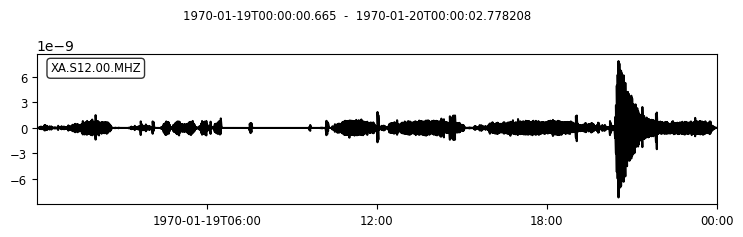

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples


In [6]:
lunar_dir = r"..\..\data\lunar"
catalog_dir = lunar_dir + r"\training\catalogs\apollo12_catalog_GradeA_final.csv"
train_dir = (
    lunar_dir
    + r"\training\data\S12_GradeA\xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed"
)
test_dir = (
    lunar_dir + r"\test\data\S12_GradeB\xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed"
)


catalog = pd.read_csv(catalog_dir)


train = obspy.read(train_dir, plot=True)


# test = process_mseed(test_dir, plot=True)
train.plot()
print(train)

### Preprocess Function


In [7]:
def preprocess_stream(stream, min_freq, max_freq, taper=0.05):
    """Apply some obspy preprocessing to the stream.

    Args:
        stream (obspy.core.stream.Stream): Seismic data stream from .mseed file.
        min_freq (float): Pass band low corner frequency.
        max_freq (float): Pass band high corner frequency. (Must be less than Nyquist frequency)
        taper (float, optional): Decimal percentage of taper at one end (ranging from 0. to 0.5). Defaults to `0.05`.

    Returns:
        obspy.core.stream.Stream: Seismic data stream from .mseed file after preprocessing.
    """
    for trace in stream:
        trace.detrend(type="linear")
        trace.taper(max_percentage=taper, type="cosine")  # Adjust taper percentage
        trace.filter("bandpass", freqmin=min_freq, freqmax=max_freq, zerophase=True)
    return stream

### FFT Plotting function to visualize frequency content


In [8]:
def plot_fft(trace):
    """Plot a graph of the Discrete Fourier Transform of the seismic data.

    Args:
        trace (obspy.core.stream.Stream): Seismic data stream from .mseed file.
    """
    npts = trace.stats.npts
    sampling_rate = trace.stats.sampling_rate
    freqs = np.fft.fftfreq(npts, d=1 / sampling_rate)
    fft_values = np.fft.fft(trace.data)

    plt.plot(np.abs(freqs), np.abs(fft_values))
    plt.title("FFT of the Seismic Data")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 0.005)  # Limit to your Nyquist frequency
    plt.show()

Original Data


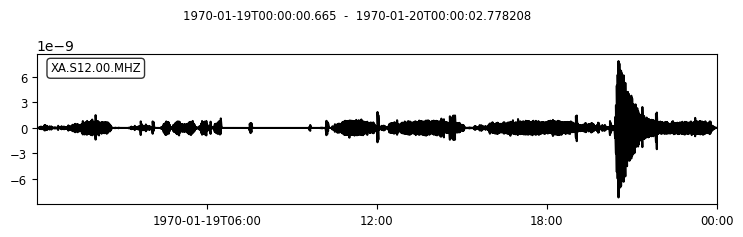

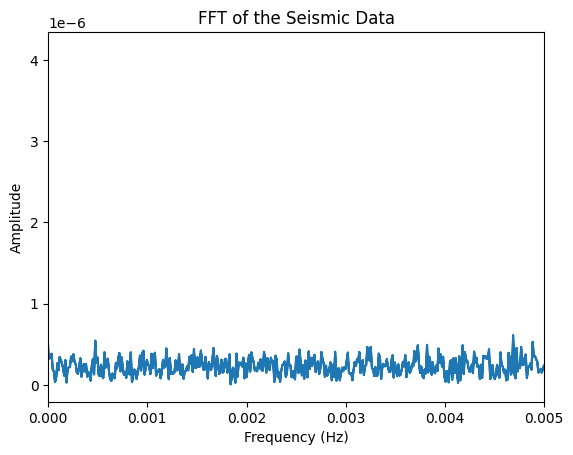

Preprocessed Data


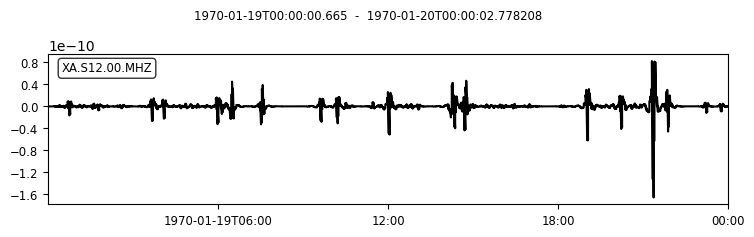

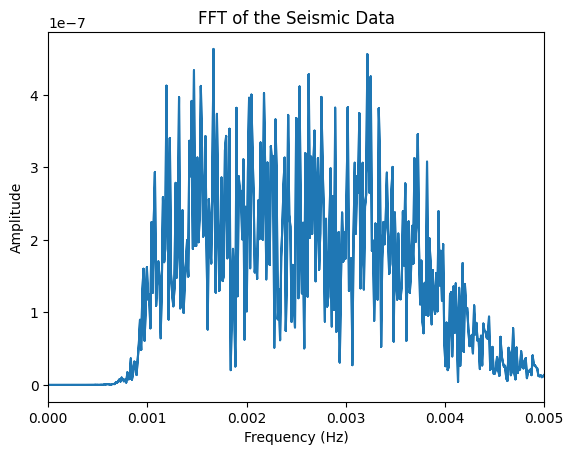

In [9]:
min_freq = 0.001  # Minimum frequency (Hz)
max_freq = 0.004  # Maximum frequency (Hz)

stream = obspy.read(train_dir)
print("Original Data")
stream.plot()
plot_fft(stream[0])


preprocessed_stream = preprocess_stream(stream.copy(), min_freq, max_freq, taper=0.03)
print("Preprocessed Data")
preprocessed_stream.plot()


plot_fft(preprocessed_stream[0])

### Event Detection


In [10]:
for trace in preprocessed_stream:
    threshold = 1.654e-10  # Define a threshold for amplitude
    for i in trace.data:
        if np.abs(i) > threshold:
            print(i)

-1.6540053220911805e-10
-1.6540553180577637e-10
-1.6540938891232933e-10
-1.654121034968536e-10
-1.6541367553993776e-10
-1.654141050346827e-10
-1.6541339198670154e-10
-1.654115364141193e-10
-1.6540853834757263e-10
-1.6540439783020914e-10


In [11]:
def get_num_windows(trace, window_size, step_size):
    """Gets how many windows there are for a given window size and step size.

    Args:
        trace (obspy.core.trace.Trace): trace of the seismic data.
        window_size (int): size of the window.
        step_size (int): step size between windows in the trace data.

    Returns:
        num_windows: number of windows in the trace data.
    """
    num_windows = (len(trace.data) - window_size) // step_size + 1

    return num_windows

In [12]:
window_size = 50  # Window size
step_size = 10  # Step size

for trace in preprocessed_stream:
    num_windows = get_num_windows(trace, window_size, step_size)
    print(f"Number of windows: {num_windows}")

Number of windows: 57237


In [13]:
def extract_features(window):
    """Returns the feature vector of a window in the seismic data.

    Args:
        window (obspy.core.trace.Trace): window of the trace of the seismic data.

    Returns:
        list: feature vector of the window.
    """
    min_amp = np.min(window)
    max_amp = np.max(window)
    mean_amp = np.mean(window)
    var_amp = np.var(window)  # Frequency spread

    skewness = skew(window, bias=False)
    kurt = kurtosis(window, bias=False)

    freq = np.abs(fft(window))

    max_freq = np.max(freq)
    max_index = np.argmax(freq)  # Peak frequency
    mean_freq = np.mean(freq)
    var_freq = np.var(freq)  # Frequency spread

    return [
        min_amp,
        max_amp,
        mean_amp,
        var_amp,
        skewness,
        kurt,
        max_freq,
        max_index,
        mean_freq,
        var_freq,
    ]

In [14]:
def get_label(window, true_anomaly_time, width=20, sampling_frequency=6.625):
    """Gets the label of a window in the seismic data.

    The label refers to whether or not the window contains the maximum amplitude of the event, defined by the catalog.

    The label is 1 if the window contains the maximum amplitude of the event, and 0 otherwise.


    Args:

        max (int): index of the maximum amplitude of the event in the seismic data.

        window (obspy.core.trace.Trace): the window of the trace of the seismic data.


    Returns:

        bool: label of the window.

    """
    delta_t = 1 / sampling_frequency
    lower_bound = true_anomaly_time - width * delta_t
    upper_bound = true_anomaly_time + width * delta_t

    # y = np.zeros(len(window))
    for i in range(len(window)):
        if lower_bound <= window[i] and window[i] <= upper_bound:
            return 1
        else:
            return 0

    # return y
    # threshold = 1e-11  # Define a threshold for amplitude

    # if np.max(np.abs(window)) > threshold:
    #     return 1  # Event detected (label as 1)

    # else:

    #     return 0  # No event detected (label as 0)

### Process and extract features


In [15]:
all_features = []
all_labels = []
print(true_anomaly_time * 6.625)
for trace in preprocessed_stream:
    feature_matrix = []
    label_vector = []

    print(len(trace.data))
    if len(trace.data) == 0:
        print("Empty trace data, skipping...")
        break

    for start in range(0, len(trace.data) - window_size + 1, step_size):
        end = start + window_size
        window = trace.data[start:end]
        # print(window)

        if len(window) < window_size:
            print(f"Skipping window due to insufficient data: {len(window)}")
            continue

        feature_vector = extract_features(window)
        if (
            start >= true_anomaly_time * 6.625 - 20
            and start <= true_anomaly_time * 6.625 + 20
        ):
            label = 1
            print(start)
        else:
            label = 0

        feature_matrix.append(feature_vector)
        label_vector.append(label)

    features = np.array(feature_matrix)
    labels = np.array(label_vector)

    if features.size > 0 and labels is not None:
        all_features.extend(features)
        all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

print(f"Features shape: {all_features.shape}")
print(f"Labels shape: {all_labels.shape}")

486937.5
572415
486920
486930
486940
486950
Features shape: (57237, 10)
Labels shape: (57237,)


In [16]:
# print(all_features)
print(np.argmax(all_labels))
print(np.count_nonzero(all_labels))

48692
4


### Train/Test Split


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.7, random_state=28
)

# Verify the shapes of the split data
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape:     {X_test.shape}")
print(f"Training labels shape:   {y_train.shape}")
print(f"Test labels shape:       {y_test.shape}")

Training features shape: (17171, 10)
Test features shape:     (40066, 10)
Training labels shape:   (17171,)
Test labels shape:       (40066,)


### Train a random forest classifier


In [18]:
clf = RandomForestClassifier(n_estimators=200, random_state=28)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=28)

### Predict on test data


In [19]:
y_pred = clf.predict(X_test)
print(np.argmax(y_pred))

0


### Evaluate the model


In [39]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9999251235461488
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40063
           1       0.00      0.00      0.00         3

    accuracy                           1.00     40066
   macro avg       0.50      0.50      0.50     40066
weighted avg       1.00      1.00      1.00     40066



c:\Users\God\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\God\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\God\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## Plot


### Hyperparameter Optimization


In [417]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


### Test on New Set
